In [1]:
include("../scripts/robot.jl")

In [2]:
using Distributions
using LinearAlgebra

In [3]:
mutable struct Particle
    pose
    weight
end

In [4]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [19]:
function observation_update(self::Particle, observation, envmap, distance_dev_rate, direction_dev)
#     print(observation)
end

observation_update (generic function with 3 methods)

In [6]:
mutable struct Mcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
end

In [11]:
function Mcl_(envmap, init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
                        distance_dev_rate=0.14, direction_dev=0.05)
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose, 1.0/num) for i in 1:num-1]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    return self
end

Mcl_ (generic function with 4 methods)

In [12]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [13]:
function observation_update(self::Mcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
end

observation_update (generic function with 3 methods)

In [14]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
end

draw (generic function with 6 methods)

In [15]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [16]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [17]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator,observation)
    return self.nu, self.omega
end

decision (generic function with 4 methods)

In [18]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
end

draw (generic function with 7 methods)

In [22]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    estimator = Mcl_(m, initial_pose, 100)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAB3pxtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGC5liIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+irUAAdvximab6tYtmIDtSY3U913HQxRgmhp/597w3yfZ52GLUciYxAXWl/cWNdO3OLelzk/jyowoJf3B3AMMnRPbQ6GhaPpBASX0ILIG7R4/0xLCQjBxlUT3CimocEIxgWHhcXsc0ItOim0ez6RJjKYdkExkbDNWNFqekX8N/NJdrhHf4bNYpJWcXLaKUNrMHhvqXZJ+SwcJ6mFfPwNPLrJv+DDpY4SVqL5R/ZIi/5yDCr5hu15WFMTKer7rQw8NJBwfqnRFZ7Cew3Pe+TX5fQhSPHSvx2lJ3rzxKYjqhdrfWMPbd5iRVT+eExjhQe/BTY6DuMlUF63LYUq7bjwAv3FIxroPIXa4aenJMEtvo7ooJHep84D37pHvRuJME7t8NoYa4eo+6F+iii01zSSrnxKX5PmjGn3PbgUq0T/+J4la1w5RzF+jODXRkoTLrcL/99u/5kIgt8aIZMkgV0e2g6bODGBmKn1F0xQeDkL4dw5zyL548wWpwgpZ4/Cg3p8JswEip7+diYYLKHtfA60He1ePZyClHswsNpvk+k8pH10UscRCocADOnfvAwPeaiIQ36Gtt7r4K8crMjIQsJY0XK6k8ZbiizyfTSs86jJbR25M2VgDc1cSYpQ6Mnf9Tw73eeSg1EvfjjpiS9DhuWBpvSKyoBy4YEaLL5DcBdM9J19ZXTbl9Y74o0La26siO88nKWOzrjRW5L3gTIcxYNSrFE38RZ+xBGCMHXT9zAtbJBez0NyFd1qEVLcbfP4XW31F4c9H6wmGcl2ANqBju7+0dwecHPCeUHu581yo14w9vnioE6r81Mh0dpAMFR1YJKDyJ0XoeHk/oetstKDrfrHfXCUZXfC9EbOJLGzT2yrQFc+30LFKZE/0dDX1K8zUDQYoUnvSCfUfpZZFpPGOlCxEI8zF0J0ZX6AbfrSPr3Ye1snQlL1AcWjINfdMsfW4/DYyB+er5LeL81APwrvOjz6WxNAg1jcQCZiEG/wtFaNKTIqOaBSQciWL2Ai57k4hvX9tTDYihiaUDypJQYhMOqH8Jo6CRakbK3KWMmNKj7kGjHxK0gX7nLRx8L86FV5gAUtGb2u8lsT14Jt6HiC90ldqTmymJ70JTQf0ngNSji+gW6BSz+rhZiWx+o1V1oi0Aqzy3Mt2Szwn7LCKUTHAvGkl4OZJs4yYCNyDH7IYQfsV8yDReNcI05z1yHxBGsCMPpAmdjZFjHv7+HmhJtLXP0HVZZpaWgDjG9w3nOWfqkmsFfEWSAHdU1CZAj6ykPmI8jmcARwpIGq9ZelO9XqOHoYUa0zWhshnfGnjxAcSP8VHviHfyJuxFxH9ODb1TjXnxy+r2V6o3ZibXmTt0dc6MUYa0hGxCMrAJRxjvAUhsysf2I8VzDL47OhM7RpaAi3sYQlmps6JPKecWy/S/MrO7GFKfP4g1SB+EeXjqgETCqv6xOg8cis+utdPRQ41PefaCaszvGvrAkr2IfNH1shS/wHeaZKOR0MGBiPldt39KS4L8O+RUXrPKUHpUAp3P/uTD3fCicknJM0gD2B9xK3EJPdQkLU8FUGCYMpQRVWa5TpRAOZRPXVf3/pAs3LefCjUE8BYzERzayhKvIjq+cQ4BG+JpbPIjAxyTeUg1xZlzRXRXFOGwgZLvCpACBayQMdWm94wKsScoXs5qLjzNNafxkp0BwCwvFBl6LqZrJ6PzjEL01cM1SXKl1NMKQzFX83X+BTwUPj5Zvec5NP1tWiPU4+smf0SYpylIiHSYk9ggV8g3jhHxdNoYMBkx455PvfZrMHeObAmxvFrmrqwfLoCkF92ZTiUhmVKpD/au0gTqNptXx3n7dGNFp58fA904JZ+nZA2WRlPqZ3orDbrxB8XRzy0+KPyw4ZQL5V0a+vEfRKDSJrxygcmo54RTGHqXmQkTygPMdqS6YuEMWUociWTAk/55Z3/ZelfUkHUAa0Q0pEFiRWoPufmVDUfhn7IoHQ4XIo0HbYZXxA8F+TlKN3EMKWeNEMpLalKYNJ7gvZ4uG/wh8qRP

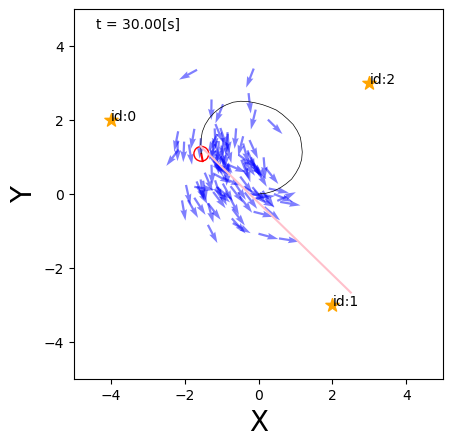

In [23]:
trial()